# **Forest Fire - Detector de Incendio**

Objetivo: Os dados foram coletados para treinar um modelo para distinguir entre as imagens que contêm fogo (imagens de fogo) e imagens regulares (imagens que não são de fogo), então todo o problema é de classificação binária..

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import os.path
from pathlib import Path
import glob
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

In [ ]:
dir_ = Path('drive/My Drive/fire_dataset')

In [ ]:
#Este código está utilizando a biblioteca pathlib para criar uma lista de caminhos de arquivos PNG.
png_filepaths = list(dir_.glob(r'**/*.png'))

In [ ]:
#labels será uma lista de rótulos correspondentes aos diretórios pai dos caminhos dos arquivos PNG.
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], png_filepaths))

In [ ]:
print(labels) #printa as listas

['non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_images', 'non_fire_i

In [ ]:
# Caminhos & labels...
filepaths = pd.Series(png_filepaths, name = 'File').astype(str)
labels = pd.Series(labels, name = 'Label')

# Concatenando...
df = pd.concat([filepaths, labels], axis=1)

# Mudando os nomes...
df['Label'].replace({"non_fire_images":"nofire","fire_images":"fire"}, inplace=True)

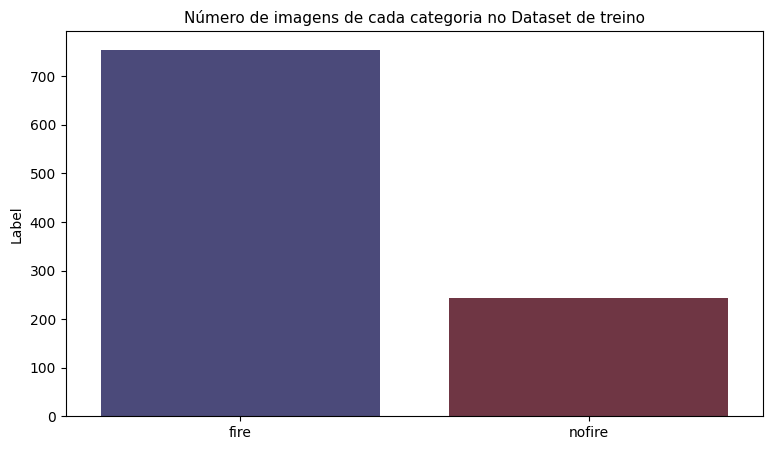

In [ ]:
# Visualizando os dados do dataset em um barplot
vc = df['Label'].value_counts()
plt.figure(figsize = (9, 5))
sns.barplot(x = vc.index, y = vc, palette = "icefire")
plt.title("Número de imagens de cada categoria no Dataset de treino", fontsize = 11)
plt.show()

As imagens acima estão desbalanceadas

In [ ]:
# Misturando o dataframe e resetando o index
df = df.sample(frac = 1, random_state = 83).reset_index(drop = True)

# Resultado
df.head()

,File,Label
0,drive/My Drive/fire_dataset/non_fire_images/no...,nofire
1,drive/My Drive/fire_dataset/fire_images/fire.5...,fire
2,drive/My Drive/fire_dataset/fire_images/fire.2...,fire
3,drive/My Drive/fire_dataset/non_fire_images/no...,nofire
4,drive/My Drive/fire_dataset/fire_images/fire.4...,fire


É necessario realizar a remoção da imagem 'non_fire.189.png' pois ela está com formato incompatível



In [ ]:
png_error = 'drive/My Drive/fire_dataset/non_fire_images/non_fire.189.png'
df = df.loc[~(df.loc[:, 'Label'] == png_error), :]


## 3. Dividindo em conjuntos de treinamento e teste



Para essa parte irei fazer a conversão dos dados em connjuntos de treinamento e teste. Ou seja , apenas realizar a separação.
Ficará 90% das imagens para treino e 10% para teste.


In [ ]:
train_df, test_df = train_test_split(df, train_size = 0.9, random_state = 86)

display(train_df.head())

test_df.head()

,File,Label
986,drive/My Drive/fire_dataset/fire_images/fire.6...,fire
333,drive/My Drive/fire_dataset/fire_images/fire.7...,fire
462,drive/My Drive/fire_dataset/non_fire_images/no...,nofire
435,drive/My Drive/fire_dataset/fire_images/fire.1...,fire
446,drive/My Drive/fire_dataset/fire_images/fire.2...,fire


,File,Label
414,drive/My Drive/fire_dataset/non_fire_images/no...,nofire
757,drive/My Drive/fire_dataset/fire_images/fire.6...,fire
393,drive/My Drive/fire_dataset/fire_images/fire.2...,fire
912,drive/My Drive/fire_dataset/fire_images/fire.1...,fire
686,drive/My Drive/fire_dataset/fire_images/fire.1...,fire


In [ ]:
# Visualizando os dados em ambos datasets
print('Dataset de treinamento:')

print(f'Número de imagens: {train_df.shape[0]}')

print(f'Número de imagens com fogo: {train_df["Label"].value_counts()[0]}')
print(f'Número de imagens sem fogo: {train_df["Label"].value_counts()[1]}\n')

print('Dataset de teste:')

print(f'Número de imagens no dataset de teste: {test_df.shape[0]}')
print(f'Número de imagens com fogo: {test_df["Label"].value_counts()[0]}')
print(f'Número de imagens sem fogo: {test_df["Label"].value_counts()[1]}')

Dataset de treinamento:
Número de imagens: 899
Número de imagens com fogo: 684
Número de imagens sem fogo: 215

Dataset de teste:
Número de imagens no dataset de teste: 100
Número de imagens com fogo: 71
Número de imagens sem fogo: 29


In [ ]:
# convertendo a Label para formato númerico para teste posteriormente
LE = LabelEncoder()

y_test = LE.fit_transform(test_df["Label"])

## 4. Observando as imagens

In [ ]:
#comando do Matplotlib usado para definir o estilo do gráfico. Neste caso específico, está configurando o estilo para um fundo escuro.
plt.style.use("dark_background")

Text(0.5, 1.0, 'fire')

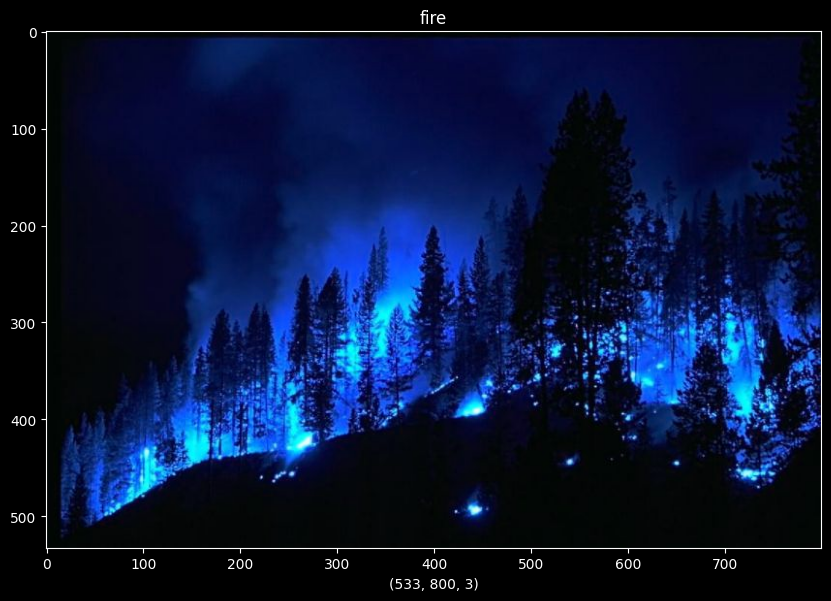

In [ ]:
# Observando as imagens do dataset de treino (fire)
figure = plt.figure(figsize=(10, 10))
x = cv2.imread(train_df["File"][986])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(train_df["Label"][986])

Text(0.5, 1.0, 'nofire')

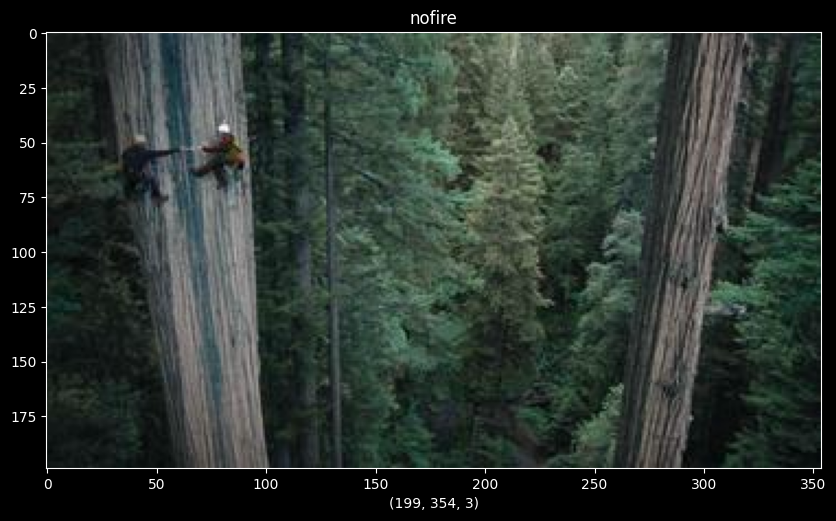

In [ ]:
# Observando as imagens do dataset de treino (nofire)
figure = plt.figure(figsize=(10,10))
x = cv2.imread(train_df["File"][910])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(train_df["Label"][910])

Text(0.5, 1.0, 'fire')

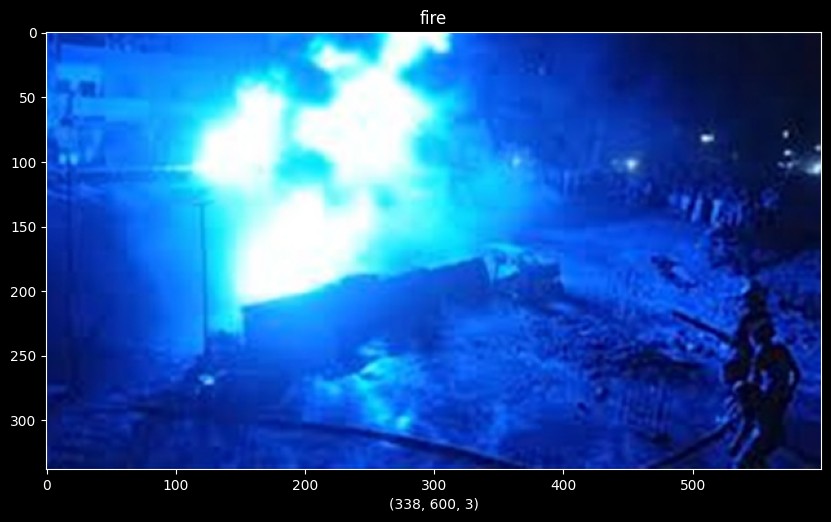

In [ ]:
# Observando as imagens do dataset de teste (fire)
figure = plt.figure(figsize = (10,10))
x = cv2.imread(test_df["File"][686])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(test_df["Label"][686])

Text(0.5, 1.0, 'nofire')

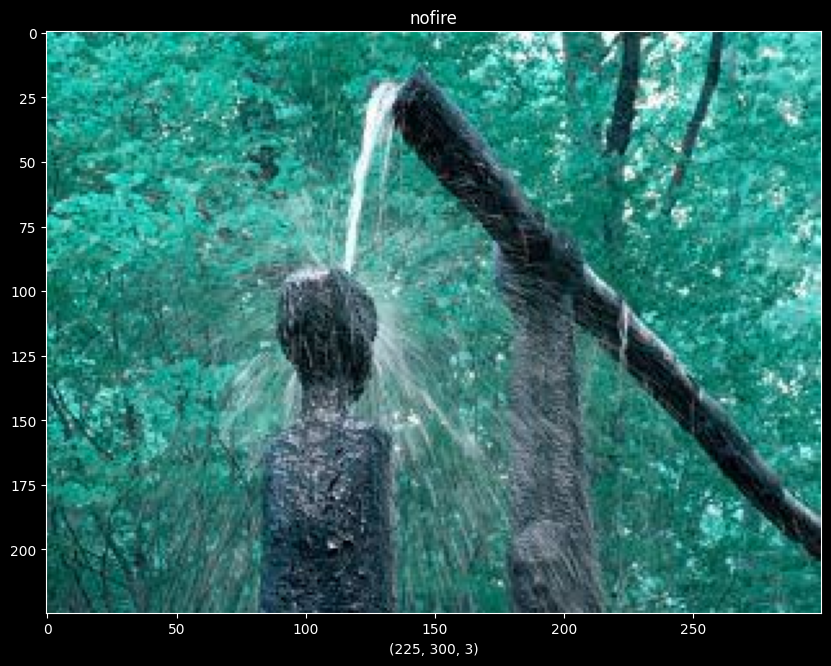

In [ ]:
# Observando as imagens do dataset de teste (nofire)
figure = plt.figure(figsize=(10,10))
x = cv2.imread(test_df["File"][978])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(test_df["Label"][978])

## 5. Pré-processamento das imagens

Nesta parte irei fazer o pré-processamento das imagens da base de dados de treinamento usando o ImageDataGenerator, para a base de dados de teste irei apenas fazer a normalização dos dados

Parametros do ImageDataGenerator:
* rescale - Transforma o tamanho da imagem (normalização dos dados)
*   shear_range - Transformações geometricas aleatórias
* zoom_range - Imagens que serão aplicadas o zoom
* brightness_range - Grau da mudança do brilho (tupla ou lista)
* rotation_range - grau da rotação da imagem
* width_shift_range - Faixa da mudança da altura da imagem
* height_shift_range - Faixa da mudança da largura da imagem
* horizontal_flip - Girar as imagens horizontalmente
* vertical_flip - Girar as imagens verticalmente
* validation_split - Imagens que ficaram reservadas para validação (0-1)

In [ ]:
#Esses são geradores de dados de imagem usando a classe ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True,
                                    validation_split = 0.1)

test_datagen = ImageDataGenerator(rescale = 1./255)

## 6. Diretório das imagens de treinamento, validação e teste

Aqui fazemos a divisão das bases de imagens para treinamento, validação e teste do modelo, para isso usamos o flow_from_dataframe

Parametro do flow_from_directory:

* dataframe - Dataframe contendo o diretório da imagem
* x_col - Nome da coluna contendo o diretório das imagens
* y_col - Nome da coluna contendo oque queremos prever
* target_size - tamanho das imagens (lembrando que deve ser do mesmo tamanho da camada de entrada)
* color_mode - Padrão de cores RGB
* class_mode - modo da classe binário (Fire/No Fire)
* batch_size - tamanho do batch
* shuffle - Embaralhar os dados
* seed - semente aleatória opcional para o shuffle
* subset - Subset dos dados sendo training e validation (apenas usado caso use validation_split no ImageDataGenerator)

In [ ]:
print("Preparando o dataset de treino...")
training_set = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col = "File",
    y_col = "Label",
    target_size = (250, 250),
    color_mode = "rgb",
    class_mode = "binary",
    batch_size = 32,
    shuffle = True,
    seed = 1,
    subset = "training")

print("Preparando o dataset de validação...")
validation_set = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col = "File",
    y_col = "Label",
    target_size = (250, 250),
    color_mode ="rgb",
    class_mode = "binary",
    batch_size = 32,
    shuffle = True,
    seed = 1,
    subset = "validation")

print("Preparando o dataset de teste...")
test_set = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    x_col = "File",
    y_col = "Label",
    target_size = (250, 250),
    color_mode ="rgb",
    class_mode = "binary",
    shuffle = False,
    batch_size = 32)

print('Geradores de dados prontos!')

Preparando o dataset de treino...
Found 810 validated image filenames belonging to 2 classes.
Preparando o dataset de validação...
Found 89 validated image filenames belonging to 2 classes.
Preparando o dataset de teste...
Found 100 validated image filenames belonging to 2 classes.
Geradores de dados prontos!


## 7. Construção do modelo (ConvNet)

As Redes Neurais Convolutivas (CNNs) representam um tipo especializado de rede neural artificial altamente eficaz na tarefa de classificação de imagens, uma vez que conseguem capturar a informação de contexto espacial, considerando a relação entre pixels vizinhos na imagem.

O processo de construção de uma CNN inicia-se com a definição do tipo de modelo a ser utilizado. No nosso cenário, optaremos por um modelo Sequential.

## Etapa 1 - Convolution
Detector de Características e Mapa de Características

Aqui, uma Rede Neural Convolutiva (CNN) está sendo construída usando o modelo Sequential. Uma camada convolucional (Conv2D) é adicionada à CNN, com 32 filtros, cada um com uma janela de convolução de dimensão (3, 3). A forma de entrada da camada é especificada como (250, 250, 3), indicando uma imagem RGB de tamanho 250x250 pixels. A função de ativação 'relu' é aplicada após a convolução. Essa camada é a primeira parte da arquitetura da CNN, destinada a extrair características da imagem.




In [ ]:
CNN = Sequential()

CNN.add(Conv2D(32, (3, 3), input_shape = (250, 250, 3), activation = 'relu'))

Etapa 2 - Max Pooling
Redução do tamanho da imagem focando nas caracteristicas mais importantes

Definição da matriz com o total de 4 pixels (2, 2)
Uma camada de MaxPooling (MaxPooling2D) é adicionada à CNN. Essa camada é frequentemente utilizada após as camadas convolucionais para reduzir a dimensionalidade espacial da representação, mantendo as características mais importantes.

In [ ]:
CNN.add(MaxPooling2D(pool_size = (2, 2)))


Etapa 3 - Camadas ocultas


In [ ]:
# Neste código, outra camada de convolução (Conv2D) é adicionada seguida por uma camada de MaxPooling (MaxPooling2D).
CNN.add(Conv2D(32, (3, 3), activation = 'relu'))
CNN.add(MaxPooling2D(pool_size = (2, 2)))

In [ ]:
#Uma camada adicional de convolução (Conv2D) é adicionada, com 64 filtros e uma janela de convolução de tamanho (3, 3),
#seguida por uma camada de Spatial Dropout (SpatialDropout2D) e outra camada de MaxPooling (MaxPooling2D).
CNN.add(Conv2D(64, (3, 3), activation = 'relu'))
CNN.add(SpatialDropout2D(0.2))
CNN.add(MaxPooling2D(pool_size = (2, 2)))

In [ ]:
# Mais uma camada de convolução (Conv2D) é adicionada à CNN, com 128 filtros e uma janela de convolução de tamanho (3, 3).
#Em seguida, há uma camada de Spatial Dropout (SpatialDropout2D) com uma taxa de dropout de 40% (0.4), e,
#finalmente, uma camada de MaxPooling (MaxPooling2D) com uma janela de tamanho (2, 2).
CNN.add(Conv2D(128, (3, 3), activation = 'relu'))
CNN.add(SpatialDropout2D(0.4))
CNN.add(MaxPooling2D(pool_size = (2, 2)))

## *Etapa* 4 - Flattening
 Transformação da matriz para um vetor para entrar na camada da Rede Neural Artificial

In [ ]:
#Essa etapa é crucial para processar e entender as características extraídas pelas camadas
#convolucionais antes de tomar decisões finais na rede neural.
CNN.add(Flatten())


## Etapa 5 - Redes Neurais Densas
Parâmetros da RNA:

A camada Dense é como uma rede completa em que cada neurônio está conectado a todos os neurônios da camada anterior. A quantidade de neurônios (units) define quantas dessas conexões existem.

A função de ativação (activation) determina como cada neurônio reage à entrada que recebe. Por exemplo, a função 'relu' retira os valores negativos, enquanto 'sigmoid' os transforma em valores entre 0 e 1.

O Dropout é uma técnica que desliga aleatoriamente alguns neurônios durante o treinamento, o que ajuda a evitar que a rede memorize os dados de treinamento (overfitting).

Quanto ao EarlyStopping, ele monitora uma métrica durante o treinamento e interrompe o processo se essa métrica não melhorar por um número definido de épocas. A opção restore_best_weights faz com que o modelo retorne aos pesos que tinham a melhor performance.

In [ ]:
#Esses resultados indicam a configuração da última parte da rede neural (CNN) que foi construida.

Camada de entrada (Input Layer):
# Camada de entrada
CNN.add(Dense(units = 256, activation = 'relu')) # A função 'relu' retira os valores negativos
CNN.add(Dropout(0.4)) # Dropout, onde 40% dos neurônios da camada anterior são desativados aleatoriamente durante o treinamento.
# Isso ajuda a prevenir overfitting

# Camada de saida (classificação binária)
CNN.add(Dense(units = 1, activation = 'sigmoid'))
# Callbacks
callbacks = [EarlyStopping(monitor = 'loss', mode = 'min', patience = 20, restore_best_weights = True)] #callback que monitora a perda durante o treinamento.

print(CNN.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 124, 124, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 61, 61, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 64)        18496     
                                                                 
 spatial_dropout2d (Spatial  (None, 59, 59, 64)        0

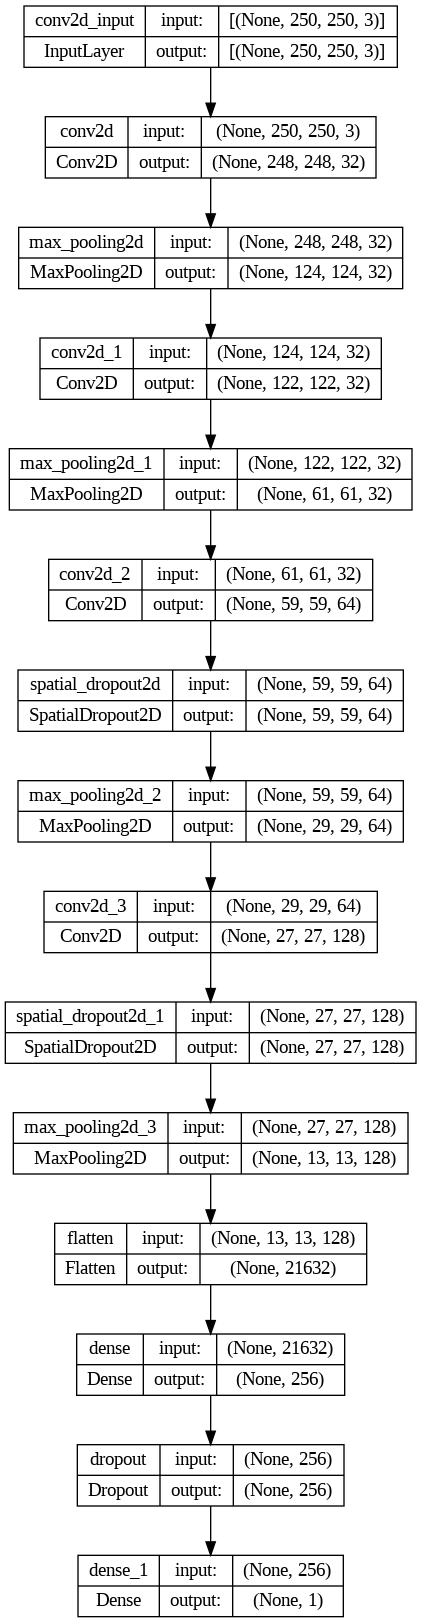

In [ ]:
#O código plot_model gera um arquivo de imagem que representa a arquitetura da rede neural convolucional (CNN).
plot_model(CNN, to_file='CNN_model.png', show_layer_names = True , show_shapes = True)
#Ao executar este código, será gerado um arquivo PNG chamado 'CNN_model.png' que ilustra a
#arquitetura da CNN com detalhes sobre as camadas, seus nomes e formas.

## Etapa 6 - Compilação e treinamento do modelo
Agora que especifiquei a arquitetura do modelo, irei compilar para o treinamento. Para isso, preciso especificar a função de perda (o que estou tentando minimizar), o otimizador (como quero fazer para minimizar a perda) e a métrica (como julgarei o desempenho do modelo). Em seguida, chamo .fit para iniciar o treinamento do processo.

Parâmetros do compile:

optimizer - descida do gradiente e descida do gradiente estocástica
loss - Função de perda (binary_crossentropy pois só há uma saída)
metrics - Métrica de avaliação (obs - pode ser colocado mais de um)

Paramêtros do fit:

train_data - base de dados de treinamento
epochs - número de épocas
validation_data - base de dados de teste
callbacks - Utilização do EarlyStopping
validation_steps - número de imagens para teste

In [ ]:
# Compilação
CNN.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
# 'adam' é utilizado para ajustar os pesos da rede durante o treinamento, visando a minimização da função de perda
#A função de perda 'binary_crossentropy' é apropriada para problemas de classificação binária.
#A métrica 'accuracy' é usada para avaliar o desempenho do modelo durante o treinamento.

# Inicio da contagem do tempo
start = dt.datetime.now()

# Treinamento
CNN_model = CNN.fit(training_set, epochs = 100, validation_data = validation_set, callbacks = callbacks)
#Callbacks, são utilizados para monitorar e interromper o treinamento se não houver melhorias na perda

# Fim da Contagem do tempo
end = dt.datetime.now()
time_CNN = end - start
print ('\nTempo de treinamento e validação: ', time_CNN)
#end = dt.datetime.now(): Encerra a contagem do tempo ao final do treinamento.
# end - start: Calcula e imprime o tempo total de treinamento e validação.

Epoch 1/100
26/26 [==============================] - 248s 10s/step - loss: 0.2855 - accuracy: 0.8802 - val_loss: 0.0969 - val_accuracy: 0.9551
Epoch 2/100
26/26 [==============================] - 60s 2s/step - loss: 0.2477 - accuracy: 0.9148 - val_loss: 0.1583 - val_accuracy: 0.9213
Epoch 3/100
26/26 [==============================] - 59s 2s/step - loss: 0.1587 - accuracy: 0.9494 - val_loss: 0.0391 - val_accuracy: 0.9888
Epoch 4/100
26/26 [==============================] - 59s 2s/step - loss: 0.0990 - accuracy: 0.9605 - val_loss: 0.0333 - val_accuracy: 0.9775
Epoch 5/100
26/26 [==============================] - 59s 2s/step - loss: 0.1992 - accuracy: 0.9420 - val_loss: 0.1940 - val_accuracy: 0.9663
Epoch 6/100
26/26 [==============================] - 58s 2s/step - loss: 0.2264 - accuracy: 0.9148 - val_loss: 0.0535 - val_accuracy: 0.9888
Epoch 7/100
26/26 [==============================] - 59s 2s/step - loss: 0.1288 - accuracy: 0.9593 - val_loss: 0.0266 - val_accuracy: 0.9888
Epoch 8/100

## 8. Histórico do treinamento do modelo

Podemos notar uma melhoria gradual na precisão ao longo do tempo, eventualmente atingindo uma estabilidade. Da mesma forma, a perda diminui ao longo do tempo. Esses gráficos são úteis para diagnosticar o overfitting. Se houvessemos notado um aumento na curva de perda de validação ao longo do tempo (semelhante a uma forma de "U" no gráfico), isso me levaria a suspeitar que o modelo estava começando a memorizar o conjunto de testes e não generalizaria bem para novos dados.

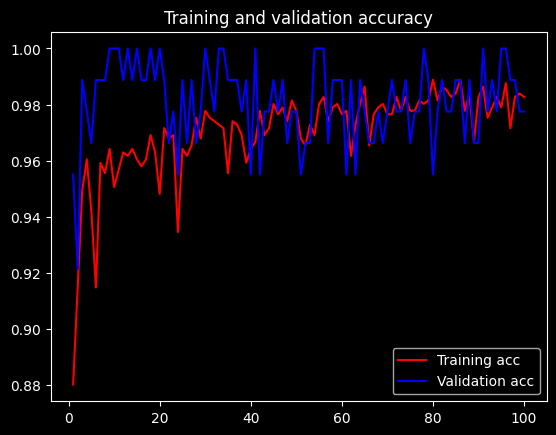

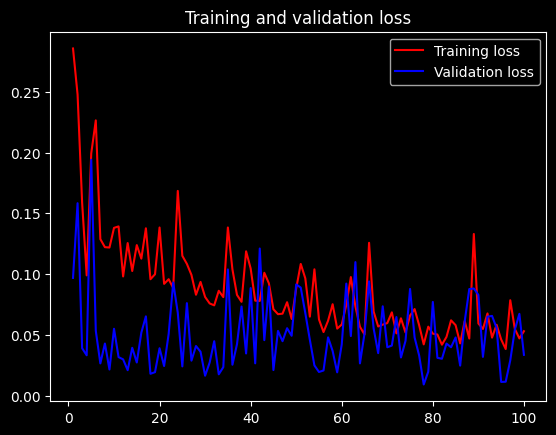

In [ ]:
acc = CNN_model.history['accuracy']
val_acc = CNN_model.history['val_accuracy']
loss = CNN_model.history['loss']
val_loss = CNN_model.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

Este gráfico mostra como a precisão e a perda evoluem ao longo do treinamento e validação. A linha vermelha representa a precisão ou perda no conjunto de treinamento, enquanto a linha azul representa a precisão ou perda no conjunto de validação.

## 9. Visualizando resultados e gerando previsoes

In [ ]:
#Esta parte do código calcula e exibe a perda (loss) e a precisão (accuracy) do modelo CNN no conjunto de teste (test_set).
score = CNN.evaluate(test_set)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

4/4 [==============================] - 21s 7s/step - loss: 0.0239 - accuracy: 1.0000
Test Loss: 0.023856015875935555
Test Accuracy: 1.0


In [ ]:
#Essas linhas de código estão relacionadas à previsão (inferência) do modelo CNN nos dados de teste e ao arredondamento das previsões.
y_pred = CNN.predict(test_set)
y_pred = np.round(y_pred)

#O resultado final (y_pred) é uma matriz de previsões binárias para cada exemplo no conjunto de teste,

4/4 [==============================] - 4s 705ms/step


In [ ]:
#Aqui o print está usando a função classification_report do módulo sklearn.metrics para gerar um
#relatório de métricas de desempenho do modelo de classificação.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        71
           1       1.00      1.00      1.00        29

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



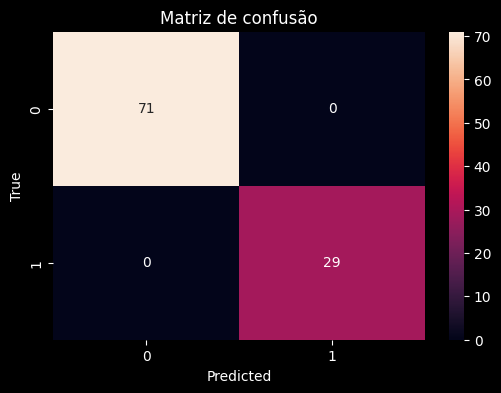

In [ ]:
plt.figure(figsize = (6, 4))

sns.heatmap(confusion_matrix(y_test, y_pred),annot = True)
plt.title("Matriz de confusão")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

* plt.figure(figsize=(6, 4)): Define o tamanho da figura para a visualização do gráfico. Neste caso, a figura terá uma largura de 6 unidades e uma altura de 4 unidades.
